In [ ]:
"""Problem Statement:
Predict whether a passenger is satisfied or dissatisfied based on flight experience and service ratings.

Tasks:
Perform EDA to find key service features influencing satisfaction.
Build interpretable models (Algo + SHAP analysis).
Create a dashboard summarizing satisfaction insights."""

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

In [5]:
df = pd.read_csv(r"D:\Cdac_ML\Assignments\Assignment_4\artifacts\data_ingestion\airplane1.csv")

In [6]:
df.head()

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,...,5,4,3,4,4,5,5,25,18.0,0
1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,...,1,1,5,3,1,4,1,1,6.0,0
2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,...,5,4,3,4,4,4,5,0,0.0,1
3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,...,2,2,5,3,1,4,2,11,9.0,0
4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,...,3,3,4,4,3,3,3,0,0.0,1


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 24 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   id                                 129880 non-null  int64  
 1   Gender                             129880 non-null  object 
 2   Customer Type                      129880 non-null  object 
 3   Age                                129880 non-null  int64  
 4   Type of Travel                     129880 non-null  object 
 5   Class                              129880 non-null  object 
 6   Flight Distance                    129880 non-null  int64  
 7   Inflight wifi service              129880 non-null  int64  
 8   Departure/Arrival time convenient  129880 non-null  int64  
 9   Ease of Online booking             129880 non-null  int64  
 10  Gate location                      129880 non-null  int64  
 11  Food and drink                     1298

In [21]:
df.isnull().sum()

id                                     0
Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             393
satisfaction                           0
dtype: int64

In [20]:
df.columns

Index(['Unnamed: 0', 'id', 'Gender', 'Customer Type', 'Age', 'Type of Travel',
       'Class', 'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes',
       'satisfaction'],
      dtype='object')

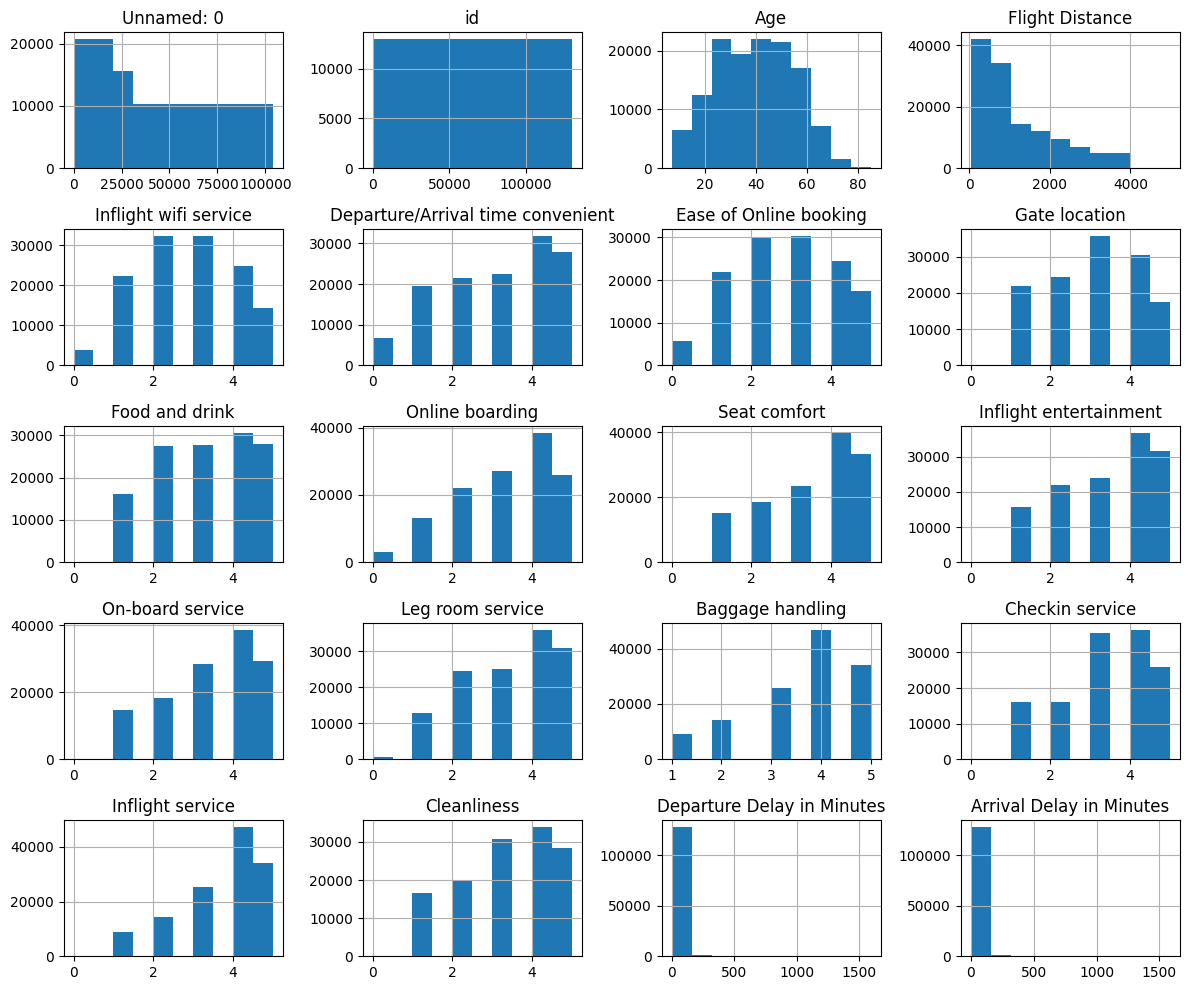

In [25]:
#to check the data distribution

df.hist(figsize=(12, 10))
plt.tight_layout()
plt.show()

In [22]:
df['Arrival Delay in Minutes'] = df['Arrival Delay in Minutes'].fillna(df['Arrival Delay in Minutes'].mean())

In [23]:
for col in ["Gender","Customer Type","Type of Travel","satisfaction","Class"]:
    print(df[col].unique())

['Male' 'Female']
['Loyal Customer' 'disloyal Customer']
['Personal Travel' 'Business travel']
['neutral or dissatisfied' 'satisfied']
['Eco Plus' 'Business' 'Eco']


In [24]:
df['satisfaction'] = df["satisfaction"].map({"neutral or dissatisfied":0, "satisfied":1})
df['satisfaction'] = df['satisfaction'].astype(int)

In [25]:
df.head()

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,...,5,4,3,4,4,5,5,25,18.0,0
1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,...,1,1,5,3,1,4,1,1,6.0,0
2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,...,5,4,3,4,4,4,5,0,0.0,1
3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,...,2,2,5,3,1,4,2,11,9.0,0
4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,...,3,3,4,4,3,3,3,0,0.0,1


In [26]:
df = df.to_csv("airplane1.csv", index = False)

In [32]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,129880.0,44158.700000,31207.377062,0.0,16234.75,38963.5,71433.25,103903.0
id,129880.0,64940.500000,37493.270818,1.0,32470.75,64940.5,97410.25,129880.0
Age,129880.0,39.427957,15.119360,7.0,27.00,40.0,51.00,85.0
Flight Distance,129880.0,1190.316392,997.452477,31.0,414.00,844.0,1744.00,4983.0
Inflight wifi service,129880.0,2.728696,1.329340,0.0,2.00,3.0,4.00,5.0
Departure/Arrival time convenient,129880.0,3.057599,1.526741,0.0,2.00,3.0,4.00,5.0
Ease of Online booking,129880.0,2.756876,1.401740,0.0,2.00,3.0,4.00,5.0
Gate location,129880.0,2.976925,1.278520,0.0,2.00,3.0,4.00,5.0
Food and drink,129880.0,3.204774,1.329933,0.0,2.00,3.0,4.00,5.0
Online boarding,129880.0,3.252633,1.350719,0.0,2.00,3.0,4.00,5.0


In [7]:
X = df.drop("satisfaction",axis=1)
y = df["satisfaction"]

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 42)

## Scaling

In [9]:

cat_cols = ['Gender', 'Customer Type', 'Type of Travel', 'Class']

ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

ohe.fit(X_train[cat_cols])

X_train_ohe = pd.DataFrame(
    ohe.transform(X_train[cat_cols]),
    columns=ohe.get_feature_names_out(cat_cols),
    index=X_train.index
)
X_test_ohe = pd.DataFrame(
    ohe.transform(X_test[cat_cols]),
    columns=ohe.get_feature_names_out(cat_cols),
    index=X_test.index
)

X_train_final = pd.concat([X_train.drop(columns=cat_cols), X_train_ohe], axis=1)
X_test_final = pd.concat([X_test.drop(columns=cat_cols), X_test_ohe], axis=1)

X_train_final, X_test_final = X_train_final.align(X_test_final, join='outer', axis=1, fill_value=0)

print(" One-Hot Encoding applied successfully!")
print("X_train_final shape:", X_train_final.shape)
print("X_test_final shape:", X_test_final.shape)


 One-Hot Encoding applied successfully!
X_train_final shape: (103904, 28)
X_test_final shape: (25976, 28)


In [10]:
from sklearn.preprocessing import StandardScaler

num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

scaler = StandardScaler()

X_train_final[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test_final[num_cols] = scaler.transform(X_test[num_cols])

print("Scaling applied on numeric features:")
print(num_cols.tolist())

Scaling applied on numeric features:
['id', 'Age', 'Flight Distance', 'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']


In [11]:
X_train_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 103904 entries, 21413 to 121958
Data columns (total 28 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   id                                 103904 non-null  float64
 1   Age                                103904 non-null  float64
 2   Flight Distance                    103904 non-null  float64
 3   Inflight wifi service              103904 non-null  float64
 4   Departure/Arrival time convenient  103904 non-null  float64
 5   Ease of Online booking             103904 non-null  float64
 6   Gate location                      103904 non-null  float64
 7   Food and drink                     103904 non-null  float64
 8   Online boarding                    103904 non-null  float64
 9   Seat comfort                       103904 non-null  float64
 10  Inflight entertainment             103904 non-null  float64
 11  On-board service                   10390

In [12]:
# Check if any column still has non-numeric data
non_numeric_cols = X_test_final.select_dtypes(include=['object']).columns.tolist()
print("Columns still containing strings:", non_numeric_cols)


Columns still containing strings: []


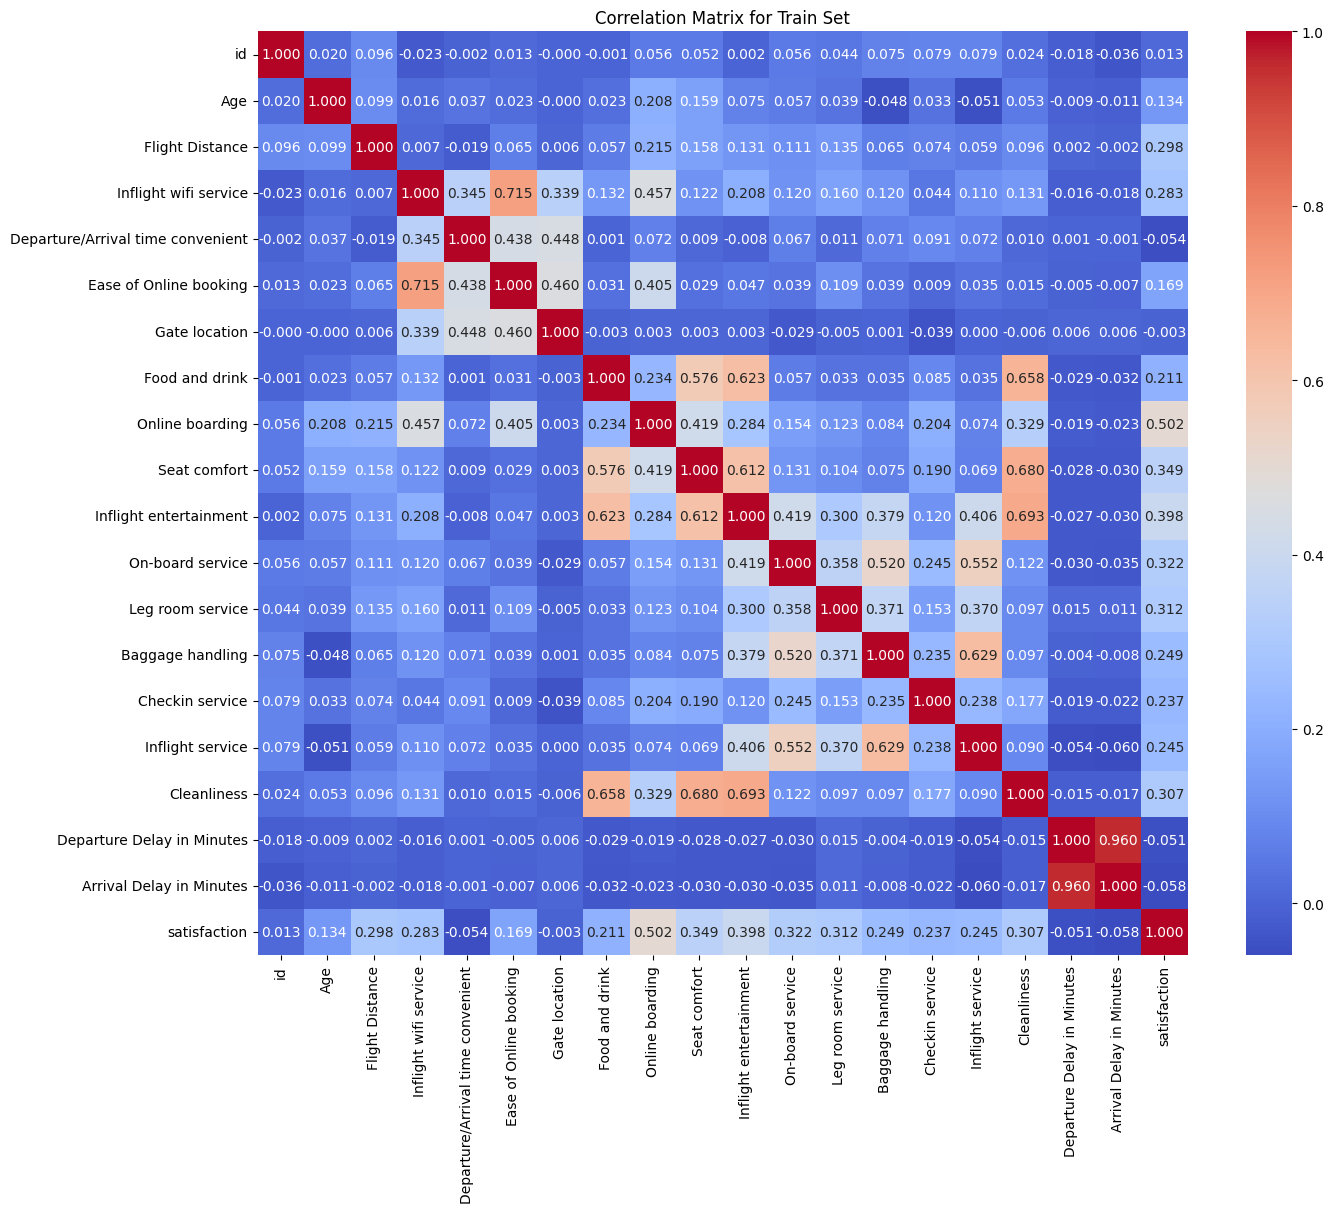

In [14]:
#Correlation
plt.figure(figsize=(15,12))
sns.heatmap(data=df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".3f")
plt.title("Correlation Matrix for Train Set")
plt.show()

In [15]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


🔹 AdaBoost Model Performance 🔹
              precision    recall  f1-score   support

           0       0.94      0.95      0.95     14622
           1       0.94      0.92      0.93     11354

    accuracy                           0.94     25976
   macro avg       0.94      0.94      0.94     25976
weighted avg       0.94      0.94      0.94     25976

ROC AUC Score: 0.9860


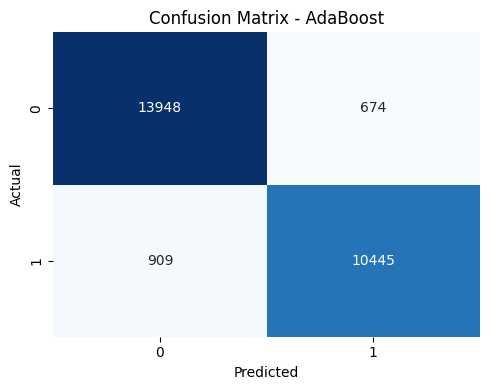

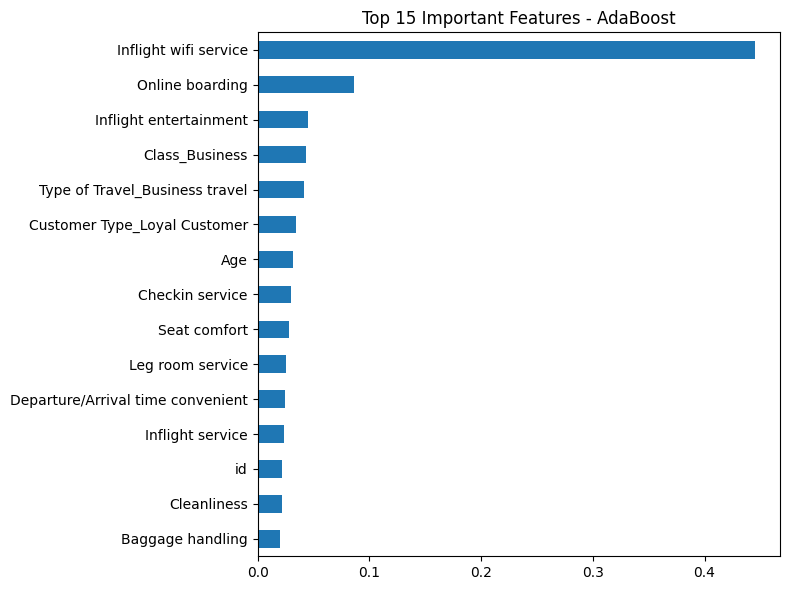

In [16]:
# 1️⃣ Define the base (weak) learner
base_model = DecisionTreeClassifier(max_depth=2, random_state=42)

# 2️⃣ Initialize AdaBoost
ada = AdaBoostClassifier(
    estimator=base_model,   # ✅ new syntax (replaces deprecated base_estimator)
    n_estimators=200,       # number of weak learners
    learning_rate=0.8,      # controls contribution of each learner
    random_state=42
)

# 3️⃣ Train the model on final preprocessed data
ada.fit(X_train_final, y_train)

# 4️⃣ Evaluate model performance
y_pred = ada.predict(X_test_final)
y_prob = ada.predict_proba(X_test_final)[:, 1]

print("\n🔹 AdaBoost Model Performance 🔹")
print(classification_report(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

# 5️⃣ Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix - AdaBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# 6️⃣ Feature Importance Visualization
feature_importance = pd.Series(ada.feature_importances_, index=X_train_final.columns).sort_values(ascending=False)

plt.figure(figsize=(8, 6))
feature_importance.head(15).plot(kind='barh')
plt.title("Top 15 Important Features - AdaBoost")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

PermutationExplainer explainer: 101it [00:51,  1.83it/s]                         


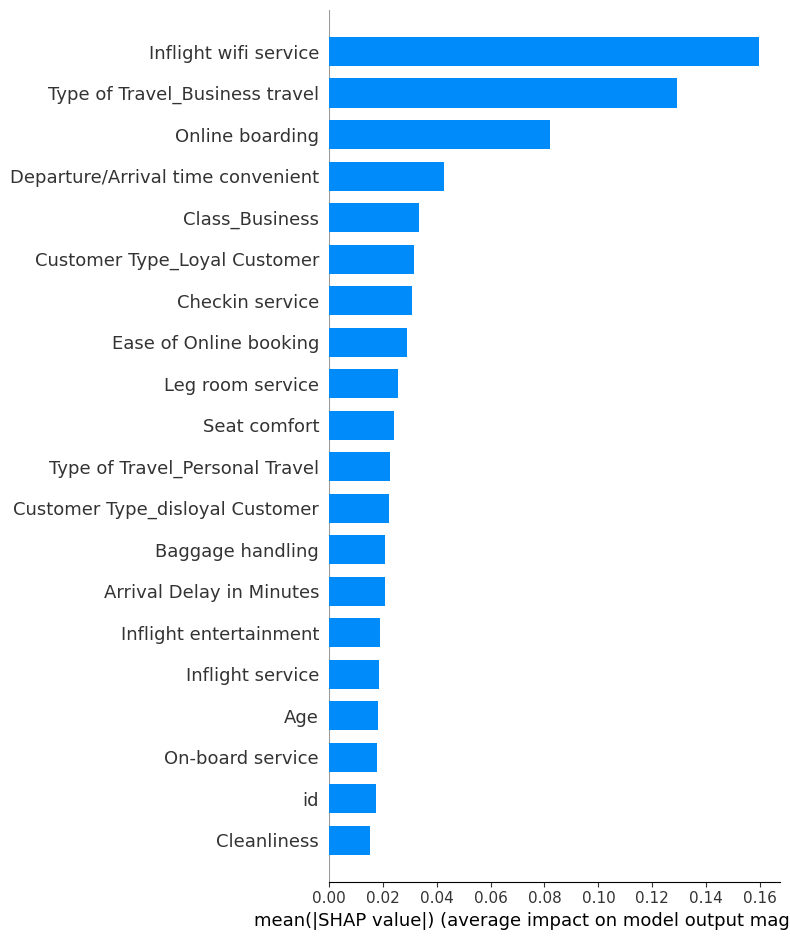

In [27]:
import shap
import numpy as np

# SHAP needs numpy arrays
X_train_shap = X_train_final.values
X_test_shap = X_test_final.values

# Create SHAP explainer (permutation-based)
explainer = shap.Explainer(
    ada.predict, 
    X_train_shap, 
    algorithm="permutation"
)

# Compute SHAP values for 100 rows
shap_values = explainer(X_test_shap[:100])

# Summary plot
shap.summary_plot(shap_values.values, X_test_final.iloc[:100], plot_type="bar")
